In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt


Professor's utility functions

In [2]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Default configuration

In [3]:
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512]
num_epochs = 20
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
norm_layer = None #norm_layer = 'BN'
print(hidden_size)



#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
#################################################################################
# TODO: Q3.a Choose the right data augmentation transforms with the right       #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################
data_aug_transforms = []
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='../datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../datasets/',
                                          train=False,
                                          transform=test_transform
                                          )

#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Using device: cuda
[128, 512, 512, 512, 512]
Files already downloaded and verified


Model definition

In [4]:
#-------------------------------------------------
# Convolutional neural network (Q1.a and Q2.a)
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ConvNet, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the convolutional layer    #
        # described in the exercise.                                                    #
        # For Q1.a make use of conv2d and relu layers from the torch.nn module.         #
        # For Q2.a make use of BatchNorm2d layer from the torch.nn module.              #
        # For Q3.b Use Dropout layer from the torch.nn module.                          #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Define the hyperparameters of the Convolutional layers 
        conv_ker_sz = (3,3) # equivalent to conv_ker_sz = 3
        padding = 'same'
        conv_stride = 1

        # Define the hyperparameters of the MaxPooling layers
        max_ker_sz = (2,2) # equivalent to max_ker_sz = 2
        max_stride = 2

        build_conv_block = lambda in_ch, out_ch: [
            nn.Conv2d(in_channels=in_ch, 
                      out_channels=out_ch, 
                      kernel_size=conv_ker_sz, padding=padding, stride=conv_stride),
            nn.MaxPool2d(kernel_size=max_ker_sz, stride=max_stride),
            nn.ReLU()
        ]

        prev_size = input_size

        for h_size in hidden_layers:
            layers += build_conv_block(in_ch=prev_size, out_ch=h_size)
            prev_size = h_size

        layers += [nn.Flatten(), 
                   nn.Linear(in_features=prev_size, out_features=num_classes)]

        self.layers = nn.ModuleList(layers)
        # self.layers = nn.Sequential(*layers)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # out = self.layers(x)
        out = x

        for layer in self.layers:
            out = layer(out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

Complete the functions

In [5]:
#-------------------------------------------------
# Calculate the model size (Q1.b)
# if disp is true, print the model parameters, otherwise, only return the number of parameters.
#-------------------------------------------------
def PrintModelSize(model, disp=True):
    #################################################################################
    # TODO: Implement the function to count the number of trainable parameters in   #
    # the input model. This useful to track the capacity of the model you are       #
    # training                                                                      #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    model_sz = sum( p.numel() for p in model.parameters() if p.requires_grad ) 

    if disp:
        print(model_sz)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model_sz



#-------------------------------------------------
# Calculate the model size (Q1.c)
# visualize the convolution filters of the first convolution layer of the input model
#-------------------------------------------------
def VisualizeFilter(model):
    #################################################################################
    # TODO: Implement the functiont to visualize the weights in the first conv layer#
    # in the model. Visualize them as a single image of stacked filters.            #
    # You can use matlplotlib.imshow to visualize an image in python                #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # Take the filters of the first convolutional layer
    weights = model.layers[0].weight.detach().numpy() if device == 'cpu' else model.layers[0].weight.detach().cpu().numpy()
    _, W, H, C = weights.shape

    # Define a lambda function to convert the values of the filters into RGB space
    to_rgb = lambda X, low, high: (255 * (X - low) / (high - low)).astype(np.int32)

    # Define the image grid
    nrows, ncols = 8, 16
    padding = 1 # padding between one image and the next
    grid_shape = (nrows*(W+padding), ncols*(H+padding), C)
    img_grid = np.zeros(shape=grid_shape, dtype=np.int32)

    for i in range(nrows): # for each row of the grid

        for j in range(ncols): # for each column of the grid
            
            img_idx = i*ncols + j # compute the image index in [0, 127]

            for ch_idx in range(C): # for each channel of the image

                # Take the minumum and maximum values of the pixels of an image
                min_val = np.min(weights[img_idx, :, :, ch_idx])
                max_val = np.max(weights[img_idx, :, :, ch_idx])
                
                # Copy the pixel RGB values into the image grid
                top = i*(H+padding) 
                left = j*(W+padding)
                img_grid[top:top+H, left:left+W, ch_idx] = to_rgb(weights[img_idx, :, :, ch_idx], min_val, max_val)

    plt.figure(num=1, figsize=(16, 8))
    plt.title('Filters of the first Convolutional Layer')
    plt.imshow(img_grid)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


### Q1.a

In [6]:
#======================================================================================
# Q1.a: Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------
model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)
# Q2.a - Initialize the model with correct batch norm layer

model.apply(weights_init)
# Print the model
print(model)

ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_f

### Q1.b

In [7]:
# Print model size
#======================================================================================
# Q1.b: Implementing the function to count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model, disp=True)

7678474


### Q1.c

In [8]:
nrows = 16
ncols = 8
weights = model.layers[0].weight.detach().cpu().numpy()

In [9]:
weights.shape

(128, 3, 3, 3)

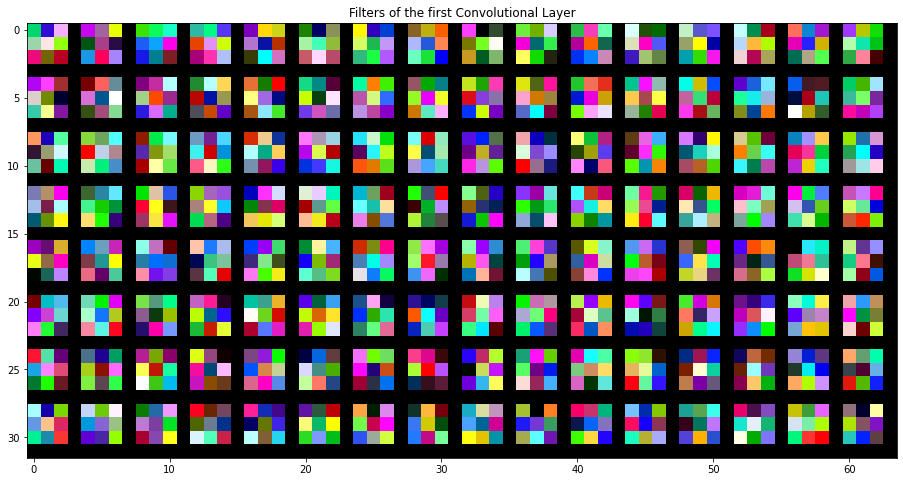

In [10]:

#======================================================================================
# Q1.c: Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
#======================================================================================
VisualizeFilter(model)

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
best_model = type(model)(input_size, hidden_size, num_classes, norm_layer=norm_layer) # get a new instance
#best_model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer)
for epoch in range(num_epochs):

    model.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    loss_train.append(loss_iter/(len(train_loader)*batch_size))

    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
        
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        print('Validation accuracy is: {} %'.format(accuracy))
        #################################################################################
        # TODO: Q2.b Implement the early stopping mechanism to save the model which has #
        # the model with the best validation accuracy so-far (use best_model).          #
        #################################################################################

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()



plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.show()



#################################################################################
# TODO: Q2.b Implement the early stopping mechanism to load the weights from the#
# best model so far and perform testing with this model.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#Compute accuracy on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))



# Q1.c: Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
VisualizeFilter(model)



# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')

KeyboardInterrupt: 